# Credit applicant data analysis and default probability prediction

Following project takes a closer look at the Kaggle dataset containing data of indian applicants for credit (full specification in the link below). 

#### Plan:
1. Data wrangling (data import, coding categorical variables, descriptive stats, map import, aggregating mean applicant's data on a state level)
2. Visualisations - heatmaps with selected variables (income, default prob., home ownership, work experience, correlation matrix)
3. Predicting loan default prob. (logistic regression)

#### Data:
* Dataset: https://www.kaggle.com/datasets/yaminh/applicant-details-for-loan-approve?resource=download
* GeoPandas map data: https://github.com/Princenihith/Maps_with_python

In [1]:
import pandas as pd
import numpy as np
import statsmodels as sm
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

## Data wrangling

In [2]:
base = pd.read_csv('/Users/macbook/Documents/Ekonomia/Applicant-details.csv')
base.head()

,Applicant_ID,Annual_Income,Applicant_Age,Work_Experience,Marital_Status,House_Ownership,Vehicle_Ownership(car),Occupation,Residence_City,Residence_State,Years_in_Current_Employment,Years_in_Current_Residence,Loan_Default_Risk
0,75722,9657655,76,0,single,rented,no,Psychologist,Jalandhar,Punjab,0,12,0
1,80185,9259353,37,18,single,rented,no,Petroleum_Engineer,Bally,West_Bengal,12,11,0
2,19865,1509721,66,8,single,rented,no,Drafter,Indore,Madhya_Pradesh,4,12,0
3,76700,5867312,43,1,single,owned,no,Chartered_Accountant,Kurnool[18],Andhra_Pradesh,1,13,1
4,92992,7223191,44,9,single,rented,no,Air_traffic_controller,Asansol,West_Bengal,9,13,0


In [3]:
#Recoded data will be used for a logistic regression, thus the name
logBase = base
logBase['Marital_Status'] = logBase['Marital_Status'].map({'single' : 0, 'married' : 1})
logBase['Vehicle_Ownership(car)'] = logBase['Vehicle_Ownership(car)'].map({'no' : 0, 'yes' : 1})
logBase['Residence_State'] = logBase['Residence_State'].replace({'Uttar_Pradesh[5]' : 'Uttar_Pradesh' })
logBase['Residence_State'] = logBase['Residence_State'].str.replace('_',' ')

houseDummies = pd.get_dummies(logBase['House_Ownership'], prefix='House_Ownership')
logBase = pd.concat([logBase, houseDummies], axis=1)
logBase.drop('House_Ownership',axis=1,inplace=True)

logBase.head()

,Applicant_ID,Annual_Income,Applicant_Age,Work_Experience,Marital_Status,Vehicle_Ownership(car),Occupation,Residence_City,Residence_State,Years_in_Current_Employment,Years_in_Current_Residence,Loan_Default_Risk,House_Ownership_norent_noown,House_Ownership_owned,House_Ownership_rented
0,75722,9657655,76,0,0,0,Psychologist,Jalandhar,Punjab,0,12,0,0,0,1
1,80185,9259353,37,18,0,0,Petroleum_Engineer,Bally,West Bengal,12,11,0,0,0,1
2,19865,1509721,66,8,0,0,Drafter,Indore,Madhya Pradesh,4,12,0,0,0,1
3,76700,5867312,43,1,0,0,Chartered_Accountant,Kurnool[18],Andhra Pradesh,1,13,1,0,1,0
4,92992,7223191,44,9,0,0,Air_traffic_controller,Asansol,West Bengal,9,13,0,0,0,1


In [4]:
#Descriptive statistics for attributes
logBase.describe()

,Applicant_ID,Annual_Income,Applicant_Age,Work_Experience,Marital_Status,Vehicle_Ownership(car),Years_in_Current_Employment,Years_in_Current_Residence,Loan_Default_Risk,House_Ownership_norent_noown,House_Ownership_owned,House_Ownership_rented
count,100000.000000,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,50000.500000,5.001617e+06,49.995400,10.110750,0.102370,0.303350,6.342990,11.996020,0.129970,0.028310,0.050810,0.920880
std,28867.657797,2.876394e+06,17.056051,5.996007,0.303136,0.459707,3.644942,1.396826,0.336272,0.165858,0.219611,0.269927
min,1.000000,1.031000e+04,21.000000,0.000000,0.000000,0.000000,0.000000,10.000000,0.000000,0.000000,0.000000,0.000000
25%,25000.750000,2.507092e+06,35.000000,5.000000,0.000000,0.000000,4.000000,11.000000,0.000000,0.000000,0.000000,1.000000
50%,50000.500000,5.004938e+06,50.000000,10.000000,0.000000,0.000000,6.000000,12.000000,0.000000,0.000000,0.000000,1.000000
75%,75000.250000,7.477502e+06,65.000000,15.000000,0.000000,1.000000,9.000000,13.000000,0.000000,0.000000,0.000000,1.000000
max,100000.000000,9.999180e+06,79.000000,20.000000,1.000000,1.000000,14.000000,14.000000,1.000000,1.000000,1.000000,1.000000


Text(0.5, 0, '')

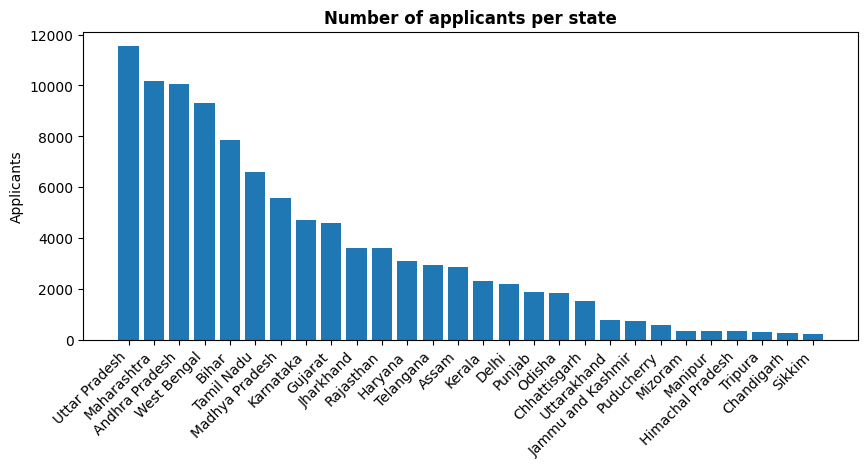

In [5]:
states = logBase['Residence_State'].value_counts()
plt.figure(figsize=(10, 4))
plt.xlabel('State')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Applicants')
plt.title('Number of applicants per state', fontweight = 'bold')
plt.bar(states.index,states.values)
plt.xlabel(None)

/var/folders/v0/14ts7p614x36xymlf7y64vn00000gn/T/ipykernel_36639/656837001.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cor = round(logBase.corr(),2)


Text(0.5, 1.0, 'Correlation matrix for microdata')

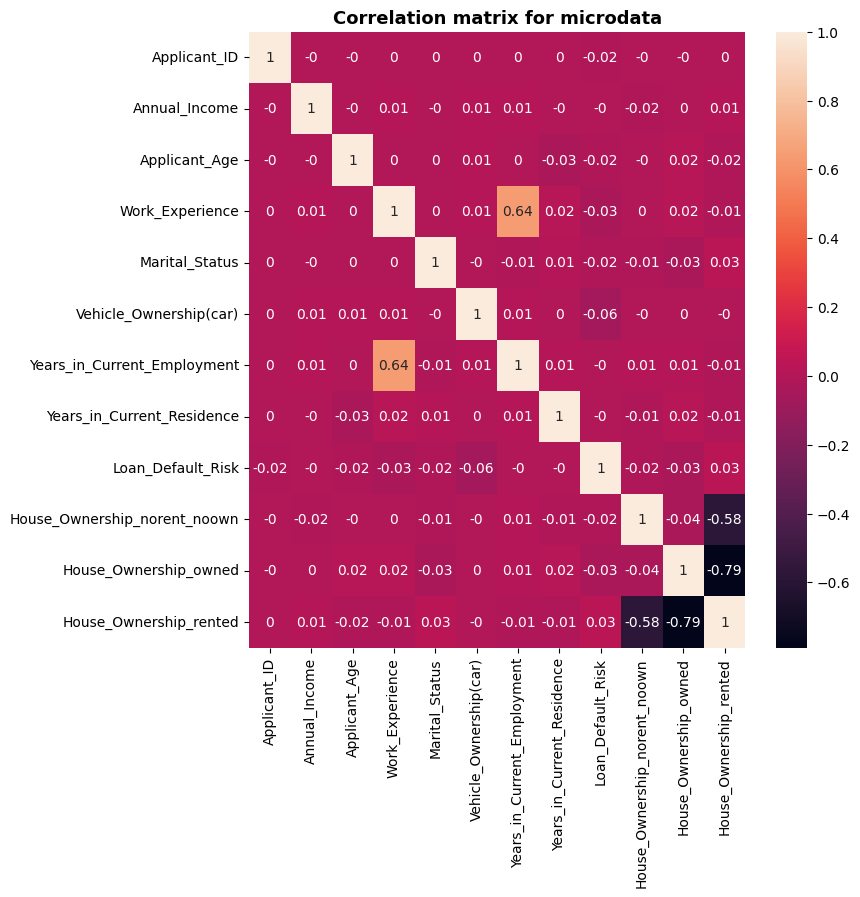

In [6]:
#Correlation matrix for an original dataset
cor = round(logBase.corr(),2)
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(cor, annot=True)
plt.title('Correlation matrix for microdata',fontweight = 'bold', fontsize = 13)

In [8]:
#Importing GeoPandas data for India
indiaStates = gpd.read_file('/Users/macbook/Downloads/Indian_States')
indiaStates = indiaStates.rename(columns={'NAME_1' : 'State'})
indiaStates.head()

,ID_0,ISO,NAME_0,ID_1,State,NL_NAME_1,VARNAME_1,TYPE_1,ENGTYPE_1,filename,filename_1,filename_2,filename_3,filename_4,geometry
0,105,IND,India,1,Andaman and Nicobar,,Andaman & Nicobar Islands|Andaman et Nicobar|I...,Union Territor,Union Territory,,,,,,"MULTIPOLYGON (((93.78773 6.85264, 93.78849 6.8..."
1,105,IND,India,2,Andhra Pradesh,,,State,State,,,,,,"MULTIPOLYGON (((80.27458 13.45958, 80.27458 13..."
2,105,IND,India,3,Arunachal Pradesh,,Agence de la Frontire du Nord-Est(French-obsol...,State,State,,,,,,"POLYGON ((96.15778 29.38310, 96.16380 29.37668..."
3,105,IND,India,4,Assam,,,State,State,,,,,,"MULTIPOLYGON (((89.87145 25.53730, 89.87118 25..."
4,105,IND,India,5,Bihar,,,State,State,,,,,,"MULTIPOLYGON (((88.10548 26.53904, 88.10505 26..."


<AxesSubplot: >

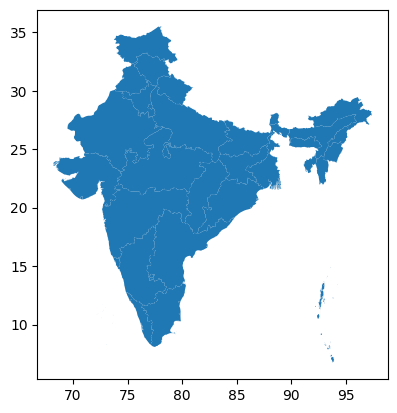

In [9]:
indiaStates.plot()

In [10]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
logBase['Annual_Income'].describe() #Income quantiles (microdata)

count    100000.00
mean    5001617.03
std     2876393.52
min       10310.00
25%     2507092.00
50%     5004938.00
75%     7477502.00
max     9999180.00
Name: Annual_Income, dtype: float64

In [11]:
#Mean annual income per state
incState = pd.DataFrame(logBase.groupby('Residence_State').agg({'Annual_Income' : 'mean' }))
incState.reset_index(inplace=True)
incState = incState.rename(columns={'Residence_State' : 'State'})

In [12]:
#Mean loan default risk per state
defState = pd.DataFrame(logBase.groupby('Residence_State').agg({'Loan_Default_Risk' : 'mean' }))
defState.reset_index(inplace=True)
defState = defState.rename(columns={'Residence_State' : 'State'})

In [13]:
#Mean home ownership per state
homeOwn = pd.DataFrame(logBase.groupby('Residence_State').agg({'House_Ownership_owned' : 'mean' }))
homeOwn.reset_index(inplace=True)
homeOwn = homeOwn.rename(columns={'Residence_State' : 'State'})

In [14]:
#Mean work experience in years per state
workExp = pd.DataFrame(logBase.groupby('Residence_State').agg({'Work_Experience' : 'mean' }))
workExp.reset_index(inplace=True)
workExp = workExp.rename(columns={'Residence_State' : 'State'})

In [15]:
#Extracting state codes
codes1 = pd.read_html('https://en.wikipedia.org/wiki/States_and_union_territories_of_India#States')[5]
codes1 = codes1.rename(columns = {'State[28]' : 'State', 'Vehicle code[30]' : 'Code'})
codesUnion = pd.read_html('https://en.wikipedia.org/wiki/States_and_union_territories_of_India#States')[6]
codesUnion = codesUnion.rename(columns = {'State[50]' : 'State', 'Vehicle code[52]' : 'Code'})

codes = pd.concat([codes1,codesUnion])
codes.reset_index(inplace=True)
codes.head()

,index,State,ISO[29],Code,Zone[31],Capital[28],Largest city[32],.mw-parser-output .tooltip-dotted{border-bottom:1px dotted;cursor:help}Established[12],Population (2011)[33][34],Area (km2)[35],...,ISO[52],Vehicle code[53],Zone[54],Capital[51],Largest city[55],Established[56],Population (2011)[57],Area (km2)[58],Official languages[59],Additional official languages[59]
0,0,Andhra Pradesh,IN-AP,AP,Southern,Amaravati,Visakhapatnam,1 November 1956,49506799.00,162975.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Arunachal Pradesh,IN-AR,AR,North-Eastern,Itanagar,Itanagar,20 February 1987,1383727.00,83743.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,Assam,IN-AS,AS,North-Eastern,Dispur,Guwahati,26 January 1950,31205576.00,78438.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,Bihar,IN-BR,BR,Eastern,Patna,Patna,26 January 1950,104099452.00,94163.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,Chhattisgarh,IN-CG,CG,Central,Raipur,Raipur,1 November 2000,25545198.00,135194.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
#Merging credit data with GeoPandas data
from functools import reduce

data = [indiaStates,incState,defState,homeOwn,workExp,codes[['State','Code']]]
merged = reduce(lambda left, right: pd.merge(left, right, on = 'State'), data)
merged.head()

,ID_0,ISO,NAME_0,ID_1,State,NL_NAME_1,VARNAME_1,TYPE_1,ENGTYPE_1,filename,filename_1,filename_2,filename_3,filename_4,geometry,Annual_Income,Loan_Default_Risk,House_Ownership_owned,Work_Experience,Code
0,105,IND,India,2,Andhra Pradesh,,,State,State,,,,,,"MULTIPOLYGON (((80.27458 13.45958, 80.27458 13...",5115024.59,0.12,0.04,10.05,AP
1,105,IND,India,4,Assam,,,State,State,,,,,,"MULTIPOLYGON (((89.87145 25.53730, 89.87118 25...",4797066.55,0.15,0.03,9.85,AS
2,105,IND,India,5,Bihar,,,State,State,,,,,,"MULTIPOLYGON (((88.10548 26.53904, 88.10505 26...",5074982.06,0.14,0.04,10.29,BR
3,105,IND,India,7,Chhattisgarh,,,State,State,,,,,,"POLYGON ((83.32760 24.09965, 83.34575 24.09707...",4999595.48,0.15,0.05,9.98,CG
4,105,IND,India,12,Gujarat,,Goudjerate|Gujerat|Gujerate,State,State,,,,,,"MULTIPOLYGON (((70.86097 20.75292, 70.86097 20...",5016423.46,0.13,0.06,10.25,GJ


In [17]:
#States not included in merged data frame
set1 = set(incState['State'])
set2 = set(indiaStates['State'])
missing = set2 - set1
print('States not mentioned in our dataset', f'({len(missing)}): ', missing)

States not mentioned in our dataset (10):  {'Orissa', 'Lakshadweep', 'Uttaranchal', 'Daman and Diu', 'Andaman and Nicobar', 'Goa', 'Dadra and Nagar Haveli', 'Arunachal Pradesh', 'Nagaland', 'Meghalaya'}


## Visualasing credit data for states in India

Text(0.5, 1.0, 'Mean annual income per state (in millions of rupees)')

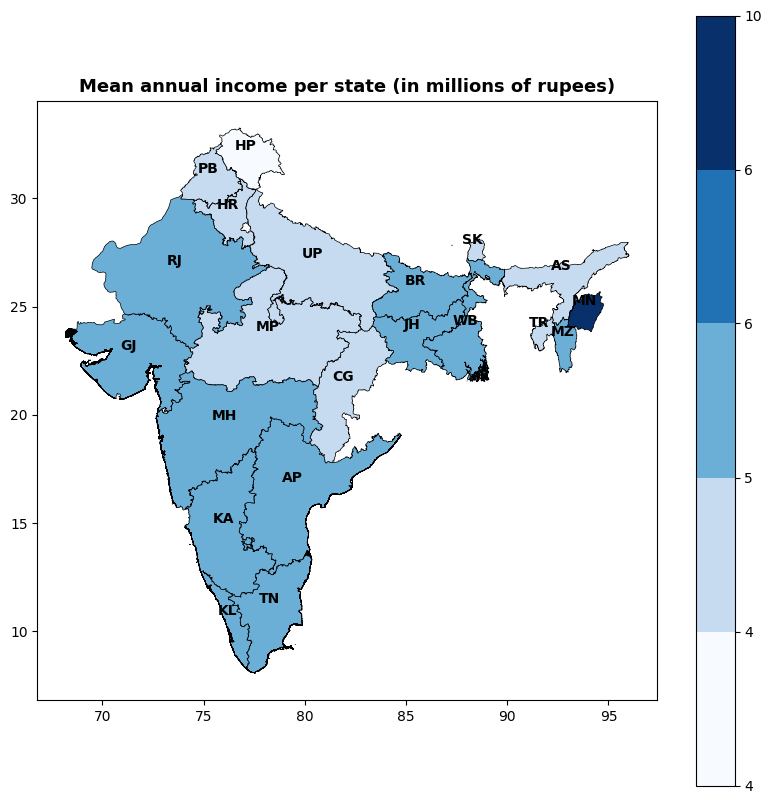

In [18]:
from matplotlib.ticker import FuncFormatter

intervals = [4000000,4500000,5000000,5500000,6000000,10000000]
cmap = plt.cm.get_cmap('Blues', 5)
norm = plt.cm.colors.BoundaryNorm(intervals, cmap.N, clip=True)

fig, ax = plt.subplots(figsize=(10, 10))
merged.plot(column='Annual_Income', cmap=cmap, norm=norm, ax=ax, legend=True, edgecolor='black', linewidth=0.5)


###Help provided by Chat GPT
# Get the colorbar
cbar = ax.get_figure().get_axes()[1]

# Convert the tick labels from billions to millions
ticks = cbar.get_yticks() / 1000000

# Define a formatter to format the tick labels as millions
def millions_formatter(x, pos):
    return '{:.0f}'.format(x)

# Apply the formatter to the colorbar ticks
cbar.yaxis.set_major_formatter(FuncFormatter(millions_formatter))
###Help provided by Chat GPT (END)


# Set the tick labels
cbar.set_yticklabels([millions_formatter(tick, None) for tick in ticks])

for idx, row in merged.iterrows():
    code = row['Code']
    centroid = row['geometry'].centroid
    ax.annotate(text=code, xy=(centroid.x, centroid.y), xytext=(-10, 5), textcoords="offset points", fontsize=10,fontweight='bold')
    
plt.title('Mean annual income per state (in millions of rupees)', fontweight='bold',fontsize=13)

Text(0.5, 1.0, 'Mean loan default probability per state')

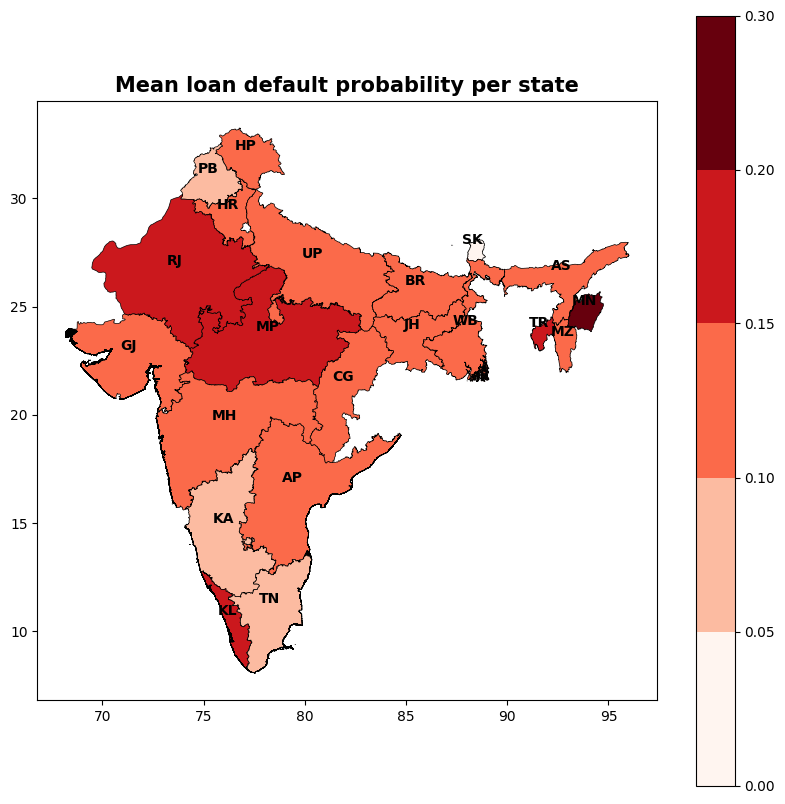

In [19]:
intervals = [0,0.05,0.1,0.15,0.2,0.3]
cmap = plt.cm.get_cmap('Reds', 5)
norm = plt.cm.colors.BoundaryNorm(intervals, cmap.N, clip=True)

fig, ax = plt.subplots(figsize=(10, 10))
merged.plot(column='Loan_Default_Risk', cmap=cmap, ax=ax, norm=norm, legend=True, edgecolor='black', linewidth=0.5)


for idx, row in merged.iterrows():
    code = row['Code']
    centroid = row['geometry'].centroid
    ax.annotate(text=code, xy=(centroid.x, centroid.y), xytext=(-10, 5), textcoords="offset points", fontsize=10, fontweight='bold')
    
plt.title('Mean loan default probability per state', fontweight='bold',fontsize=15)

Text(0.5, 1.0, 'Mean work experience per state (years)')

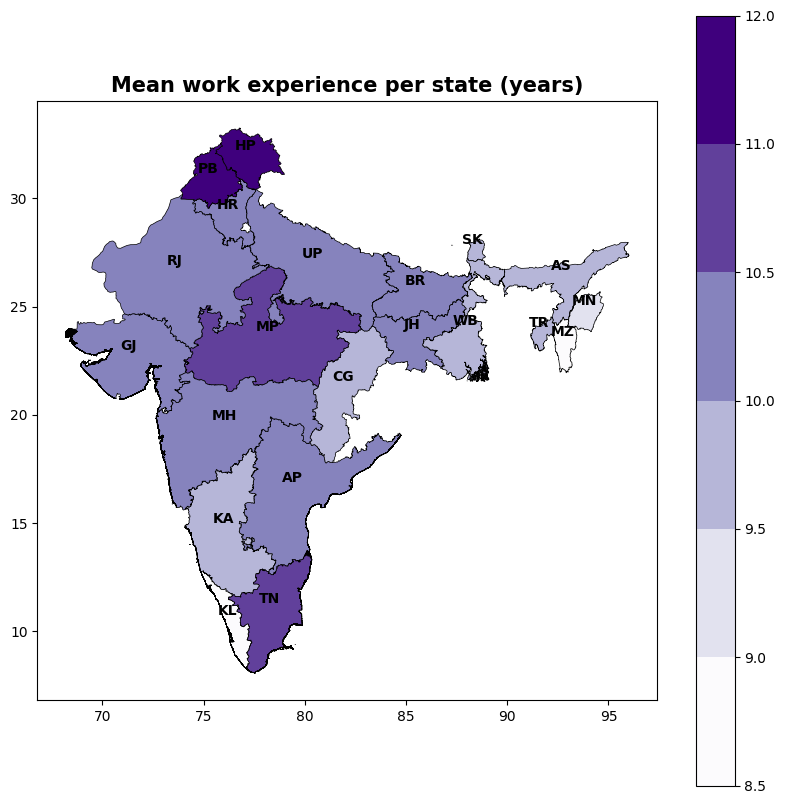

In [20]:
intervals = [8.5,9,9.5,10,10.5,11,12]
cmap = plt.cm.get_cmap('Purples', 6)
norm = plt.cm.colors.BoundaryNorm(intervals, cmap.N, clip=True)

fig, ax = plt.subplots(figsize=(10, 10))
merged.plot(column='Work_Experience', cmap=cmap, ax=ax, norm=norm, legend=True, edgecolor='black', linewidth=0.5)


for idx, row in merged.iterrows():
    code = row['Code']
    centroid = row['geometry'].centroid
    ax.annotate(text=code, xy=(centroid.x, centroid.y), xytext=(-10, 5), textcoords="offset points", fontsize=10, fontweight='bold')
    
plt.title('Mean work experience per state (years)', fontweight='bold',fontsize=15)

Text(0.5, 1.0, 'Mean house ownerhship per state (as fraction of applicants)')

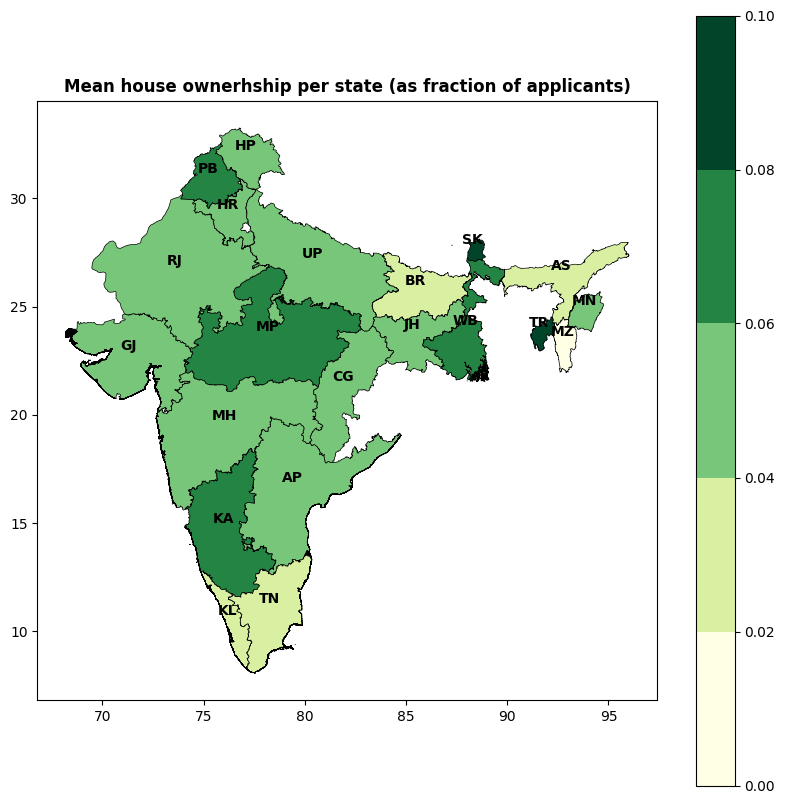

In [21]:
intervals = [0,0.02,0.04,0.06,0.08,0.1]
cmap = plt.cm.get_cmap('YlGn', 5)
norm = plt.cm.colors.BoundaryNorm(intervals, cmap.N, clip=True)

fig, ax = plt.subplots(figsize=(10, 10))
merged.plot(column='House_Ownership_owned', cmap=cmap, ax=ax, norm=norm, legend=True, edgecolor='black', linewidth=0.5)


for idx, row in merged.iterrows():
    code = row['Code']
    centroid = row['geometry'].centroid
    ax.annotate(text=code, xy=(centroid.x, centroid.y), xytext=(-10, 5), textcoords="offset points", fontsize=10, fontweight='bold')
    
plt.title('Mean house ownerhship per state (as fraction of applicants)', fontweight='bold',fontsize=12)

(array([0.5, 1.5, 2.5, 3.5]),
 [Text(0.5, 0, 'Annual_Income'),
  Text(1.5, 0, 'Work_Experience'),
  Text(2.5, 0, 'Loan_Default_Risk'),
  Text(3.5, 0, 'House_Ownership_owned')])

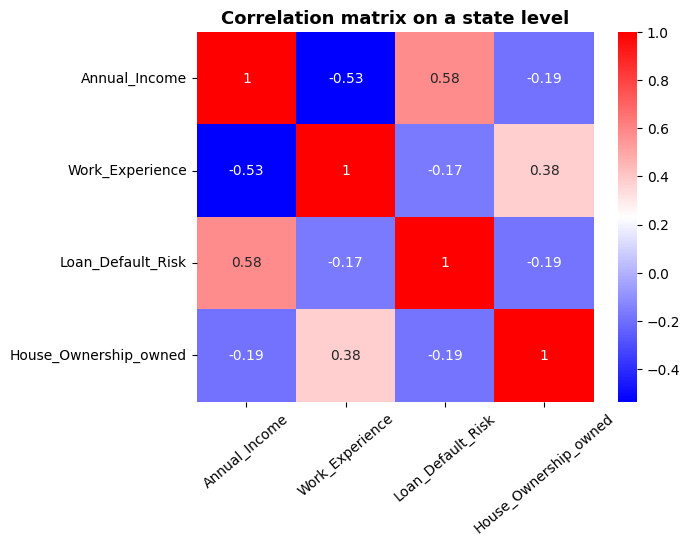

In [22]:
stateData = merged[['Annual_Income','Work_Experience','Loan_Default_Risk','House_Ownership_owned']]
sns.heatmap(stateData.corr(),cmap='bwr',annot=True)
plt.title('Correlation matrix on a state level', fontweight = 'bold', fontsize = 13)
plt.xticks(rotation=40)

## Logistic regression for Loan Default Risk

In [23]:
logBase.head()

,Applicant_ID,Annual_Income,Applicant_Age,Work_Experience,Marital_Status,Vehicle_Ownership(car),Occupation,Residence_City,Residence_State,Years_in_Current_Employment,Years_in_Current_Residence,Loan_Default_Risk,House_Ownership_norent_noown,House_Ownership_owned,House_Ownership_rented
0,75722,9657655,76,0,0,0,Psychologist,Jalandhar,Punjab,0,12,0,0,0,1
1,80185,9259353,37,18,0,0,Petroleum_Engineer,Bally,West Bengal,12,11,0,0,0,1
2,19865,1509721,66,8,0,0,Drafter,Indore,Madhya Pradesh,4,12,0,0,0,1
3,76700,5867312,43,1,0,0,Chartered_Accountant,Kurnool[18],Andhra Pradesh,1,13,1,0,1,0
4,92992,7223191,44,9,0,0,Air_traffic_controller,Asansol,West Bengal,9,13,0,0,0,1


In [24]:
import statsmodels.api as sm

#Adding intercept
logBase['inter'] = 1

#Explanatory variables
X = logBase[['inter','Annual_Income', 'Applicant_Age', 'Work_Experience', 'Marital_Status', 'Years_in_Current_Employment', 'House_Ownership_owned', 'House_Ownership_rented', 'House_Ownership_norent_noown',]]

#Explained variable
y = logBase['Loan_Default_Risk']

#Model
model = sm.Logit(y,X)
results = model.fit()

Optimization terminated successfully.
         Current function value: 0.384727
         Iterations 6


In [25]:
print(results.summary())

                           Logit Regression Results                           
Dep. Variable:      Loan_Default_Risk   No. Observations:               100000
Model:                          Logit   Df Residuals:                    99992
Method:                           MLE   Df Model:                            7
Date:                Wed, 13 Mar 2024   Pseudo R-squ.:                0.004147
Time:                        18:38:55   Log-Likelihood:                -38473.
converged:                       True   LL-Null:                       -38633.
Covariance Type:            nonrobust   LLR p-value:                 2.585e-65
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
inter                           -1.3865    6.6e+05   -2.1e-06      1.000   -1.29e+06    1.29e+06
Annual_Income                -4.202e-09   3.28e-09     -1.283      0.199   -1

### Results commentary

According to the regression table, the statistically significant variables (p-value < 0.1) include: 
* Applicant's age (in years)
* Work experience (in years)
* Martial status (1 - married, 0 - not married)
* Job tenure (in years)

The effects calculated:
* One additional year of age **lowers** log-likeleyhood of default by **0.0037**
* One additional year of work experience **lowers** log-likeleyhood of default by **0.0206**
* Married applicants display **lower** log-likeleyhood of default by **0.2139**
* One additional year of job tenure **increases** log-likeleyhood of default by **0.0187** (counterintuitive; requires further investigation)
